In [2]:
import pandas as pd
import numpy as np
import time
import datetime
import os
import xgboost as xgb
from utils import raw_data_path,dump_pickle,load_pickle,cal_log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import lightgbm as lgb
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['figure.figsize'] = [12, 8]
param = {
         'max_depth': 6,
         'eta': 0.1,
         'silent': 1,
         'n_estimators': 1000,
         'objective': 'binary:logistic',
         "eval_metric": "logloss",
         'min_child_weight': 10,
         "colsample_bytree": 0.3
    }

if __name__ == '__main__':
    
    
    t0 = time.time()
    train_data = load_pickle(path='../data/train_final_onehot.pkl')    
    train_Y = train_data['is_trade']
    train_data.drop('is_trade', axis=1, inplace=True) 

    
    cv_data = load_pickle(path='../data/valid_final_onehot.pkl')
    cv_Y = cv_data['is_trade']
    cv_data.drop('is_trade', axis=1, inplace=True) 

    
    test_data = load_pickle(path='../data/test_final_onehot.pkl')
    test_Y = test_data['is_trade']
    test_data.drop('is_trade', axis=1, inplace=True) 

    print('train shap:',train_data.shape)
    print('cv shape', cv_data.shape)
    print('test shape', test_data.shape)
    
    
    test_file = 'round1_ijcai_18_test_b_20180418.txt'
    test = pd.read_table(raw_data_path + test_file,delim_whitespace=True)
    test_id = test.instance_id
    
    drop_cols = ['context_id', 'user_id', 'shop_id', 'item_id','item_brand_id', 'instance_id']

    train_data.drop(drop_cols,axis=1,inplace=True)
    cv_data.drop(drop_cols,axis=1,inplace=True)
    test_data.drop(drop_cols,axis=1,inplace=True)
    
#     train_data = pd.concat([train_data, cv_data], axis=0).reset_index(drop=True)
#     train_Y =  pd.concat([train_Y, cv_Y], axis=0).reset_index(drop=True)
    
    xgb_train = xgb.DMatrix(train_data, label=train_Y)
    xgb_cv = xgb.DMatrix(cv_data, label=cv_Y)
    xgb_test = xgb.DMatrix(test_data)
    
    xgbm = xgb.train(param,           
                    xgb_train,     
                    num_boost_round = 1000,
                    evals = [(xgb_train, 'train'), (xgb_cv, 'valid')],
                    verbose_eval=20,       
                    early_stopping_rounds=50)
    
    
    
    
#     print('预测正样本比例:'(predict_test>=0.5).sum()/len(predict_test))
#     '''
#     ##############################
#                 特征选择
#     #############################
#     '''
#     feat_imp = pd.Series(gbm.get_fscore(), index=train_data.columns).sort_values(ascending=False)[:150]
#     train_data = train_data[feat_imp]
#     test_data = test_data[feat_imp]
    
#     xgb_train = xgb.DMatrix(train_data, label=train_Y)
#     xgb_test = xgb.DMatrix(test_data, label=test_Y)
    
#     xgbm = xgb.train(param,           
#                     xgb_train,     
#                     num_boost_round = 1000,
#                     evals = [(xgb_train, 'train'), (xgb_test, 'valid')],
#                     verbose_eval=20,       
#                     early_stopping_rounds=50)

train shap: (420676, 357)
cv shape (57411, 357)
test shape (42888, 357)
[0]	train-logloss:0.605197	valid-logloss:0.605127
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.


KeyboardInterrupt: 

In [8]:
train_data = pd.concat([train_data, cv_data], axis=0)
train_Y = np.append(train_Y, cv_Y)
xgb_train = xgb.DMatrix(train_data, label=train_Y)
xgbm = xgb.train(param,           
                xgb_train,
                evals = [(xgb_train, 'training')],
                verbose_eval = 20,
                num_boost_round =118)
predict_test = xgbm.predict(xgb_test)

submission = pd.DataFrame({'instance_id':test_id,'predicted_score':predict_test})
print('预测正样本比例:',len(submission.loc[submission.predicted_score>=0.5])/len(submission))
submission.to_csv(r'../result/xgb_{}.txt'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')),
              index=False, sep=' ',line_terminator='\r')

[0]	training-logloss:0.604898
[20]	training-logloss:0.121125
[40]	training-logloss:0.085686
[60]	training-logloss:0.081319
[80]	training-logloss:0.07907
[100]	training-logloss:0.077539
[117]	training-logloss:0.076637
预测正样本比例: 0.0


In [31]:
feat_imp = pd.Series(xgbm.get_fscore(), index=train_data.columns).sort_values(ascending=False).index[:150]
train_data = train_data[feat_imp]
test_data = test_data[feat_imp]

xgb_train = xgb.DMatrix(train_data, label=train_Y)
xgb_test = xgb.DMatrix(test_data, label=test_Y)

xgbm = xgb.train(param,           
                xgb_train,     
                num_boost_round = 1000,
                evals = [(xgb_train, 'train'), (xgb_test, 'valid')],
                verbose_eval=20,       
                early_stopping_rounds=50)

[0]	train-logloss:0.605106	valid-logloss:0.604669
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[20]	train-logloss:0.122992	valid-logloss:0.118823
[40]	train-logloss:0.087734	valid-logloss:0.083132
[60]	train-logloss:0.083728	valid-logloss:0.079911
[80]	train-logloss:0.08177	valid-logloss:0.079685
[100]	train-logloss:0.080307	valid-logloss:0.079605
[120]	train-logloss:0.07925	valid-logloss:0.079803
[140]	train-logloss:0.078117	valid-logloss:0.079564
[160]	train-logloss:0.077213	valid-logloss:0.079768
[180]	train-logloss:0.076377	valid-logloss:0.079842
Stopping. Best iteration:
[143]	train-logloss:0.077959	valid-logloss:0.07949



In [24]:
feat_imp

time_diff_last_query_x                     204.0
user_id_count                              168.0
diff_maxtime_item_id_y                     146.0
diff_mintime_item_brand_id_y               138.0
shop_score_delivery                        137.0
shop_id_smooth_rate                        127.0
time_diff_last_query_y                     119.0
diff_mintime_item_id_y                     106.0
_item_sales_level_groupby_shop_id_mean     102.0
shop_score_service                          94.0
_user_star_level_groupby_item_id_mean       94.0
predict_category_property0                  93.0
user_age_level_smooth_rate                  93.0
item_brand_id_smooth_rate                   92.0
item_id_smooth_rate                         90.0
item_time_diff_last_query                   87.0
diff_maxtime_item_brand_id_y                86.0
predict_category_property3                  84.0
user_id_day_search                          84.0
predict_category_property1                  80.0
shop_score_descripti

In [20]:
# test_x= xgb.DMatrix(test_data)
predict_test = xgbm.predict(test_data)
print((predict_test>=0.5).sum()/len(predict_test))

3.483652958492275e-05


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x10e700908>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/core.py", line 337, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x10e49e208>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/core.py", line 337, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


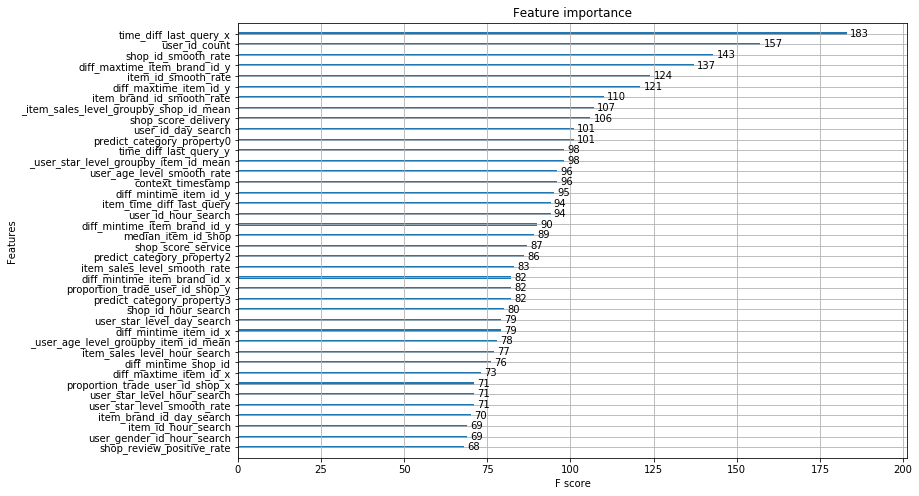

In [28]:
xgb.plot_importance(xgbm, max_num_features=40)
plt.show()